**Tip:** If you get error messages running this program (e.g. by changing the country or the starting year, then choose under Kernel "Restart & run all." The Restart bit is important.

We start by loading the modules that we will need for our program. We use two different commands:

- `import module as module_name` : This loads the module `module` under the name `module_name` which
  is the name which we refer the module to. That is, to call a function from the module we will need
  to use the command `module_name.function()`.
- `from module import function` : This loads a specific function from the module. Importantly, to use
  the function in the code below we only need to call `function()`.
- Note that `module_name.function()` and `function()` perform exactly the same tasks.

If you get a "module not found" error when use the import command, then the module needs to be installed. If you use Anaconda, then you can do this as follows:
- Open a separate "terminal window" and type: conda install anaconda::numpy (or whatever the module is that needs to be installed)

The modules we will be using are the following.

- `Numpy`: This is the fundamental package/module for scientific computing in Python.
- `get_regression_coefs_general`: This is the .py file that contains the linear regression function of the same
name. This is to show that you can of course also create your own modules as .py files.
- `Pandas`: This is the fundamental module for data anlysis in Python. This is used for loading,
cleaning and analysing data.
- `Matplolib`: This is the fundamental module for plotting.

**Tip:** Python has excellent documentation. If you do not understand the properties of a function and
/ or are looking for other features check them online, e.g. [Numpy](https://numpy.org/doc/stable/index.html), [Pandas](https://pandas.pydata.org/docs/index.html), [Matplotlib](https://matplotlib.org/).

In [800]:
# 1) import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')



In [801]:
# 2.1) Load dataset

data = pd.read_excel('pwt110_download_2025_11_24.xlsx', sheet_name='Data')
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(data.head())

Shape: (13690, 51)
Columns: ['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo', 'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck', 'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'pl_k']
  countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc  \
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN   
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   
2         ABW   Aruba  Aruban Guilder  1952    NaN    NaN  NaN  NaN  NaN NaN   
3         ABW   Aruba  Aruban Guilder  1953    NaN    NaN  NaN  NaN  NaN NaN   
4         ABW   Aruba  Aruban Guilder  1954    NaN    NaN  NaN  NaN  NaN NaN   

   ...  csh_x  csh_m  csh_r  pl_c  pl

In [802]:
# 2.1) Load dataset
data = pd.read_excel('pwt110_download_2025_11_24.xlsx', sheet_name = 'Data')

In [803]:
data.columns

Index(['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo',
       'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck',
       'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna',
       'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo',
       'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'csh_c',
       'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g',
       'pl_x', 'pl_m', 'pl_n', 'pl_k'],
      dtype='object')

In [804]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# select your country as a country
data = data.loc[data["country"] == "Sri Lanka", ("year", "rgdpe", "rgdpe_pc")]

# Reset the index (not crucial)
data = data.reset_index(drop=True)

# Subset the RGDP per capita series
ymax = 2023
ymin = 1950

# For GDP PER CAPITA 
Y_pc = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y_pc = np.log(Y_pc)

# For TOTAL GDP 
Y_gdp = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe"]
y_gdp = np.log(Y_gdp)

# Filter data 
data = data[data["year"] >= ymin]  # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y_pc)  # sample size used for regression. len(Y_gdp) would be the same
T_all = data["year"].max() - (ymin - 1)  # number of all years in the data after ymin

In [805]:
# See the cleaned data for Sri Lanka
print(data)

    year          rgdpe      rgdpe_pc
0   1950   25357.488281   3456.990971
1   1951   27267.125000   3610.934647
2   1952   24134.570312   3102.942043
3   1953   25326.912109   3160.501812
4   1954   28594.119141   3467.465989
..   ...            ...           ...
69  2019  322498.687500  14390.483889
70  2020  289517.468750  12832.193306
71  2021  309878.718750  13650.821174
72  2022  287845.812500  12605.485163
73  2023  283839.718750  12356.105308

[74 rows x 3 columns]


```# 3) Compute different trend specifications```

Next, we want to compute four different specifications: (i) additive + linear (ii) additive + quadratic
(iii) exponential + linear and (iv) exponential + quadratic. This notebook only generates the results for the linear additive model, you will have to program the results for the other three cases yourself.

We will not do anything extraordinary, but simply run a linear regression. In Stata, you would run
`reg y x1 x2`. In R, you would run `lm(formula = y ~ x1 + x2, data)`. We will run
`get_regression_coefs(y, x1, x2)` in Python. The difference is that you can understand what's going on under the hood of your
program by looking at get_regression_coefs yourself

To see what `get_regression_coefs(y, x1, x2)` does in more details see the get_regression_coefs.py
file or simply type  'help(get_regression_coefs)` in a code window.

This program only generates the results for the linear additive model. You will have to program the results for the other three cases yourself.

In terms of presenting the results, it is important that you present them in a way such that the four different approaches are comparable and transparent. If not, then the discussion is unlikely to be convincing. 


## 3.1 Additive Linear Model

In [806]:
# 3.1.1) Additive Linear Model for BOTH Total GDP and GDP Per Capita

# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is GDP in *levels*

x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty(T)  # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1  # recall that Python starts indexing at 0

# ===== For TOTAL GDP =====
a_add_lin_gdp, b_add_lin_gdp = get_regression_coefs(Y_gdp, x1, x2)

# ===== For GDP PER CAPITA =====
a_add_lin_pc, b_add_lin_pc = get_regression_coefs(Y_pc, x1, x2)

Having computed the coefficients, we can now evaluate the trend for the entire time series, i.e.
also for years later than those used in the regression.

In [807]:
# ===== Predictions for TOTAL GDP =====
# Initialise predicted values Yhat
Yhat_add_lin_gdp = np.empty(T)  # Changed from T_all to T

# Create loop to compute trend for all years
for t in range(T):  # Changed from T_all to T
    Yhat_add_lin_gdp[t] = a_add_lin_gdp + b_add_lin_gdp * (t + 1)

# Let us convert into log-units
yhat_add_lin_gdp = np.log(Yhat_add_lin_gdp)


# ===== Predictions for GDP PER CAPITA =====
# Initialise predicted values Yhat
Yhat_add_lin_pc = np.empty(T)  # Changed from T_all to T

# Create loop to compute trend for all years
for t in range(T):  # Changed from T_all to T
    Yhat_add_lin_pc[t] = a_add_lin_pc + b_add_lin_pc * (t + 1)

# Let us convert into log-units
yhat_add_lin_pc = np.log(Yhat_add_lin_pc)

/var/folders/3l/x_n29jbd5dv5hq7x97zwtkw40000gn/T/ipykernel_25278/1971518352.py:10: RuntimeWarning: invalid value encountered in log
  yhat_add_lin_gdp = np.log(Yhat_add_lin_gdp)


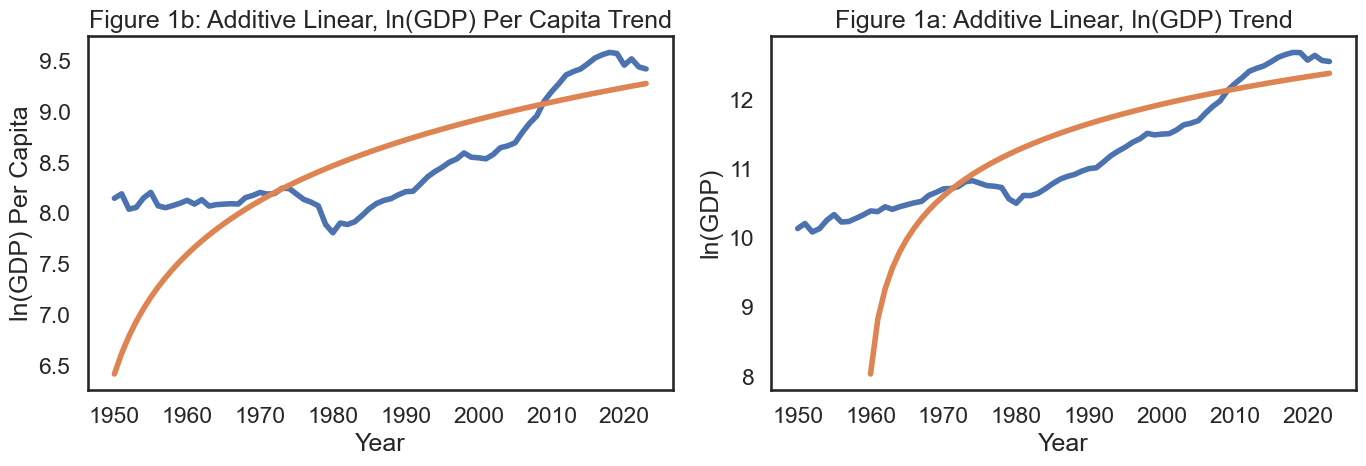

In [808]:
lw = 4

# Figure 1: Additive Linear - Two panels

plt.figure(figsize=(14, 5))

# Panel 1b: GDP Per Capita (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw)
plt.plot(data['year'], yhat_add_lin_pc, linewidth=lw)
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 1b: Additive Linear, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))  # Ticks every 10 years: 1950, 1960, 1970, ...

# Panel 1a: Total GDP (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw)
plt.plot(data['year'], yhat_add_lin_gdp, linewidth=lw)
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 1a: Additive Linear, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))  # Ticks every 10 years: 1950, 1960, 1970, ...

plt.tight_layout()
plt.show()

NOTES TO DELETE AFTER

This plots the results of Model 3.1 (Linear Additive):

- Blue line: Actual log(GDP) data points
- Orange line: The fitted linear trend (yhat_add_lin)

# A. Trend calculation

# 3.2 Additive Quadratic Model

In [809]:
# 3.2) Additive Quadratic Model for BOTH Total GDP and GDP Per Capita
# First regressor x1 is T x 1 vector of ones
# Other regressors: linear term (t) and quadratic term (t²)
# The dependent variable is GDP in *log levels*

x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty((T, 2))  # initialise a 2D array for linear and quadratic terms

for t in range(T):
    x1[t] = 1.
    x2[t, 0] = t + 1           # linear term
    x2[t, 1] = (t + 1)**2      # quadratic term

In [810]:
# ===== For TOTAL GDP =====
a_add_quad_gdp, b_add_quad_lin_gdp, b_add_quad_sq_gdp = get_regression_coefs(y_gdp, x1, x2[:, 0], x2[:, 1])

# Initialise predicted values
yhat_add_quad_gdp = np.empty(T)

# Create loop to compute trend
for t in range(T):
    yhat_add_quad_gdp[t] = a_add_quad_gdp + b_add_quad_lin_gdp * (t + 1) + b_add_quad_sq_gdp * ((t + 1)**2)


# ===== For GDP PER CAPITA =====
a_add_quad_pc, b_add_quad_lin_pc, b_add_quad_sq_pc = get_regression_coefs(y_pc, x1, x2[:, 0], x2[:, 1])

# Initialise predicted values
yhat_add_quad_pc = np.empty(T)

# Create loop to compute trend
for t in range(T):
    yhat_add_quad_pc[t] = a_add_quad_pc + b_add_quad_lin_pc * (t + 1) + b_add_quad_sq_pc * ((t + 1)**2)

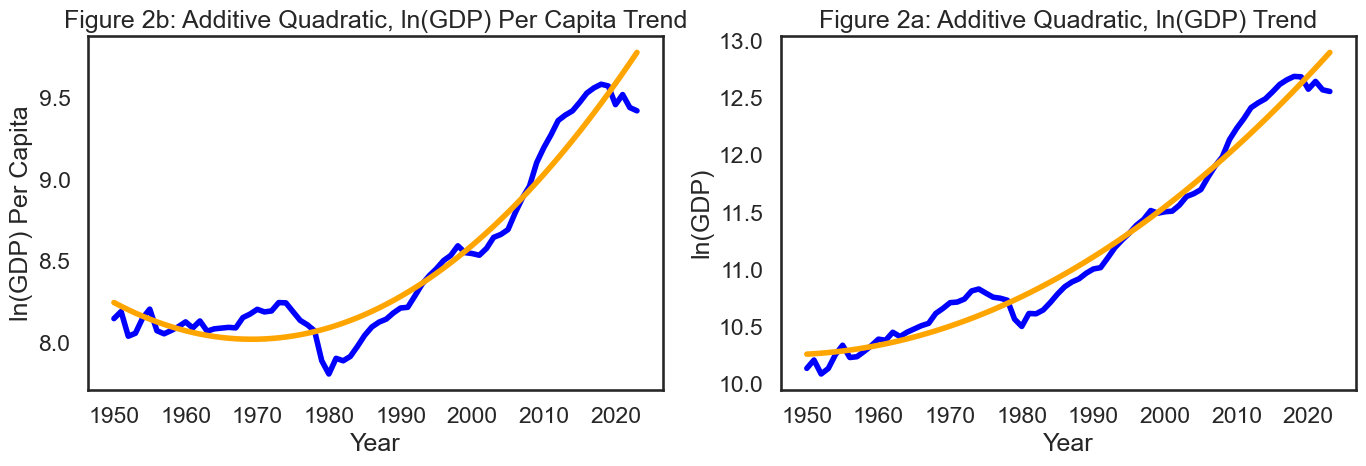

In [811]:
lw = 4

# Figure 2: Additive Quadratic - Two panels

plt.figure(figsize=(14, 5))

# Panel 2b: GDP Per Capita (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_add_quad_pc, linewidth=lw, color='orange')
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 2b: Additive Quadratic, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))  # Ticks every 10 years

# Panel 2a: Total GDP (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_add_quad_gdp, linewidth=lw, color='orange')
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 2a: Additive Quadratic, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))  # Ticks every 10 years

plt.tight_layout()
plt.show()

In [812]:
print(f"Linear coefficient: {b_add_quad_lin_gdp}")
print(f"Quadratic coefficient: {b_add_quad_sq_gdp}")

Linear coefficient: 0.0023488384912740932
Quadratic coefficient: 0.0004494488555070858


NOTES: claude is telling me that the reason for U-shaped trend is due to: 

> The economic problem:
You're right - GDP shouldn't have a declining trend!
The quadratic is over-fitting to the dip around 1980 (Sri Lankan civil war period). It's treating that as part of the "trend" rather than a deviation.

> What this tells you:
This is actually a useful finding for your project:

> "The quadratic specification produces an economically implausible declining trend in early years, suggesting it over-fits to the 1980s conflict period rather than capturing true long-run growth."

DOUBLE CHECK THIS

# 3.3 Linear Exponential Model 

In [813]:
# 3.3) Exponential Linear Model for BOTH
# Need to rebuild x1 and x2!

x1 = np.empty(T)
x2 = np.empty(T)  # 1D array, NOT (T, 2)!

for t in range(T):
    x1[t] = 1.
    scaled_t = (t + 1) / 100
    x2[t] = np.exp(scaled_t)  # Just one column

In [814]:
# ===== For TOTAL GDP =====
a_exp_lin_gdp, b_exp_lin_gdp = get_regression_coefs(Y_gdp, x1, x2)

Yhat_exp_lin_gdp = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_lin_gdp[t] = a_exp_lin_gdp + b_exp_lin_gdp * np.exp(scaled_t)

yhat_exp_lin_gdp = np.log(Yhat_exp_lin_gdp)

# ===== For GDP PER CAPITA =====
a_exp_lin_pc, b_exp_lin_pc = get_regression_coefs(Y_pc, x1, x2)

Yhat_exp_lin_pc = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_lin_pc[t] = a_exp_lin_pc + b_exp_lin_pc * np.exp(scaled_t)

yhat_exp_lin_pc = np.log(Yhat_exp_lin_pc)

/var/folders/3l/x_n29jbd5dv5hq7x97zwtkw40000gn/T/ipykernel_25278/3334936000.py:9: RuntimeWarning: invalid value encountered in log
  yhat_exp_lin_gdp = np.log(Yhat_exp_lin_gdp)


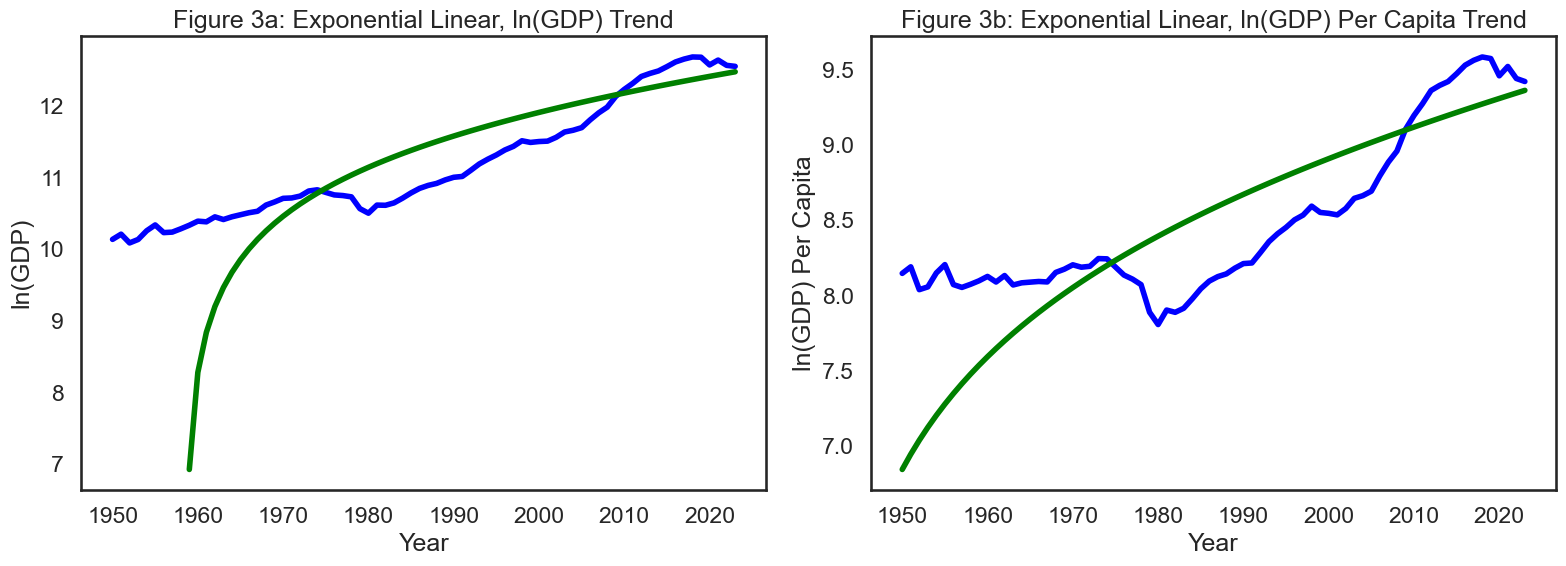

In [815]:
lw = 4

# Figure 3: Exponential Linear - Two panels

plt.figure(figsize=(16, 6))

# Panel 3a: Total GDP (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_exp_lin_gdp, linewidth=lw, color='green')
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 3a: Exponential Linear, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))

# Panel 3b: GDP Per Capita (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_exp_lin_pc, linewidth=lw, color='green')
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 3b: Exponential Linear, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))

plt.tight_layout()
plt.show()

# 3.4 Exponential Quadratic Model

In [816]:
# 3.4) Exponential Quadratic Model for BOTH Total GDP and GDP Per Capita
# First regressor x1 is T x 1 vector of ones
# Other regressors: exp(t) and t·exp(t)
# The dependent variable is GDP in *levels* (not logged)

x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty((T, 2))  # initialise a 2D array for exponential terms

for t in range(T):
    x1[t] = 1.
    scaled_t = (t + 1) / 100  # Scale down the time variable
    x2[t, 0] = np.exp(scaled_t)
    x2[t, 1] = scaled_t * np.exp(scaled_t)


In [817]:
# ===== For TOTAL GDP =====
a_exp_quad_gdp, b_exp_quad_exp_gdp, b_exp_quad_texp_gdp = get_regression_coefs(Y_gdp, x1, x2[:, 0], x2[:, 1])

Yhat_exp_quad_gdp = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_quad_gdp[t] = a_exp_quad_gdp + b_exp_quad_exp_gdp * np.exp(scaled_t) + b_exp_quad_texp_gdp * scaled_t * np.exp(scaled_t)

# Convert to logs for plotting
yhat_exp_quad_gdp = np.log(Yhat_exp_quad_gdp)


# ===== For GDP PER CAPITA =====
a_exp_quad_pc, b_exp_quad_exp_pc, b_exp_quad_texp_pc = get_regression_coefs(Y_pc, x1, x2[:, 0], x2[:, 1])

Yhat_exp_quad_pc = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_quad_pc[t] = a_exp_quad_pc + b_exp_quad_exp_pc * np.exp(scaled_t) + b_exp_quad_texp_pc * scaled_t * np.exp(scaled_t)  # Use scaled_t!

# Convert to logs for plotting
yhat_exp_quad_pc = np.log(Yhat_exp_quad_pc)

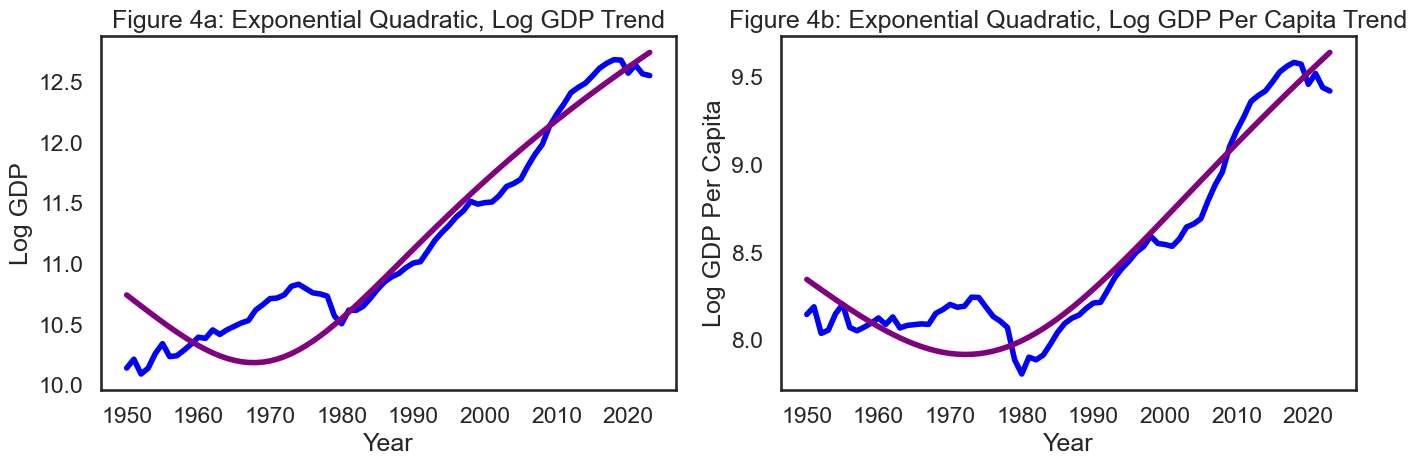

In [818]:
lw = 4

# Figure 4: Exponential Quadratic - Two panels

plt.figure(figsize=(14, 5))

# Panel 4a: Total GDP (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_exp_quad_gdp, linewidth=lw, color='purple')
plt.xlabel("Year")
plt.ylabel("Log GDP")
plt.title("Figure 4a: Exponential Quadratic, Log GDP Trend")
plt.xticks(range(1950, 2030, 10))

# Panel 4b: GDP Per Capita (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue')
plt.plot(data['year'], yhat_exp_quad_pc, linewidth=lw, color='purple')
plt.xlabel("Year")
plt.ylabel("Log GDP Per Capita")
plt.title("Figure 4b: Exponential Quadratic, Log GDP Per Capita Trend")
plt.xticks(range(1950, 2030, 10))

plt.tight_layout()
plt.show()

# B. Extract TFP Measure

**Production Function**

The Cobb-Douglas production function with human capital is:

$$
Y = K^{\alpha}(AhL)^{1-\alpha}, \quad 0 < \alpha < 1
$$

Where:
- $Y$: Real GDP (output)
- $K$: Capital stock
- $L$: Employment (number of workers)
- $h$: Human capital index
- $A$: Total Factor Productivity (TFP)
- $\alpha$: Capital share of output = **0.3**

**Solving for TFP**

Rearranging to solve for $A$:

$$
A = \frac{Y^{1/(1-\alpha)}}{K^{\alpha/(1-\alpha)} \cdot h \cdot L}
$$

Or equivalently in **log form**:

$$
\ln(A) = \frac{1}{1-\alpha}\ln(Y) - \frac{\alpha}{1-\alpha}\ln(K) - \ln(h) - \ln(L)
$$

With $\alpha = 0.3$:

$$
\ln(A) = \frac{1}{0.7}\ln(Y) - \frac{0.3}{0.7}\ln(K) - \ln(h) - \ln(L)
$$

$$
\ln(A) \approx 1.429\ln(Y) - 0.429\ln(K) - \ln(h) - \ln(L)
$$

**Data Variables**

From Penn World Table:
- **$Y$**: `rgdpna` (real GDP at constant 2017 national prices)
- **$K$**: `rnna` (capital stock at constant 2017 national prices)
- **$L$**: `emp` (number of employed workers)
- **$h$**: `hc` (human capital index)

In [819]:
# Load data again 
data_tfp = pd.read_excel('pwt110_download_2025_11_24.xlsx', sheet_name='Data')

# Subset relevant columns for TFP calculation
data_tfp = data_tfp.loc[:, ["country", "year", "rgdpna", "rnna", "emp", "hc"]]

# Filter to Sri Lanka
data_tfp = data_tfp.loc[data_tfp["country"] == "Sri Lanka", ["year", "rgdpna", "rnna", "emp", "hc"]]

# Reset index
data_tfp = data_tfp.reset_index(drop=True)

# Filter years
ymin = 1950
ymax = 2023
data_tfp = data_tfp[(data_tfp["year"] >= ymin) & (data_tfp["year"] <= ymax)]

In [820]:
# Set parameter
alpha = 0.3  # Capital share (benchmark value)

# Rename columns for clarity
data_tfp = data_tfp.rename(columns={
    'rgdpna': 'Y',
    'rnna': 'K',
    'emp': 'L',
    'hc': 'h'
})

# Extract variables from your data
Y = data_tfp["Y"].values  # Aggregate real GDP
K = data_tfp["K"].values  # Aggregate capital stock
L = data_tfp["L"].values  # Total employment
h = data_tfp["h"].values  # Human capital per worker

# Compute TFP with human capital (aggregate levels)
# Production function: Y = A · K^α · (h·L)^(1-α)
# Solving for A: A = Y / (K^α · (h·L)^(1-α))
A = Y / (K**alpha * (h * L)**(1 - alpha))

# Add TFP to dataframe
data_tfp['TFP'] = A

# Compute log TFP for easier interpretation
data_tfp['ln_TFP'] = np.log(A)

# Display first few rows with all columns
print("First 5 rows:")
data_tfp.head()

First 5 rows:


,year,Y,K,L,h,TFP,ln_TFP
0,1950,13178.016602,22397.904297,2.499192,1.483648,260.853339,5.563958
1,1951,14071.486328,23717.240234,2.555272,1.493016,268.392063,5.592449
2,1952,14925.839844,25058.650391,2.613895,1.502442,274.404615,5.614604
3,1953,14264.401367,25995.390625,2.674440,1.511928,254.126489,5.537832
4,1954,15341.320312,27000.187500,2.732963,1.521474,264.986663,5.579679


In [821]:
# Test robustness to different alpha values using LOGS
alphas = [0.25, 0.3, 0.35, 0.4]

for a in alphas:
    ln_tfp_col = f'ln_TFP_alpha_{a}'
    A = Y / (K**a * (h * L)**(1 - a))
    data_tfp[ln_tfp_col] = np.log(A)

# Display results in logs
print("Under different alpha values:")
data_tfp[['year', 'ln_TFP_alpha_0.25', 'ln_TFP_alpha_0.3', 'ln_TFP_alpha_0.35', 'ln_TFP_alpha_0.4']].head()

Under different alpha values:


,year,ln_TFP_alpha_0.25,ln_TFP_alpha_0.3,ln_TFP_alpha_0.35,ln_TFP_alpha_0.4
0,1950,5.999271,5.563958,5.128646,4.693333
1,1951,6.029199,5.592449,5.155699,4.718949
2,1952,6.052656,5.614604,5.176552,4.738500
3,1953,5.976260,5.537832,5.099405,4.660977
4,1954,6.018606,5.579679,5.140753,4.701826


# C. Growth accounting

In [ ]:
# We define a function that calculate yearly growth rates using log growth rates
def compute_growth_rate(X):
    # use of index slicing, e.g. X[1:] are all values starting from the second element, X[:-1] all elements up until (but not including) the last
    return np.log(X[1:] / X[:-1])  

# Extract variables 
Y = data_tfp["Y"].values
K = data_tfp["K"].values
L = data_tfp["L"].values
h = data_tfp["h"].values
A = data_tfp["TFP"].values

# Calculate growth rates
dY = compute_growth_rate(Y)
dA = compute_growth_rate(A)
dK = compute_growth_rate(K)
dL = compute_growth_rate(L)
dh = compute_growth_rate(h)
dHL = compute_growth_rate(h * L)

# Get years array
year = data_tfp['year'].values

# Display growth rates
print("\t year by year growth rate (first five years)\n")
print("\t year \t \t ln(Y_t/Y_{t-1}) \t ln(A_t/A_{t-1}) \t ln(K_t/K_{t-1}) \t ln(HL_t/HL_{t-1})")

# Print first 5
for y1, y2, gy, ga, gk, ghl in zip(year[:5], year[1:6], dY[:5], dA[:5], dK[:5], dHL[:5]):
    print(f"\t {y1:.0f}-{y2:.0f} \t {gy:.4f} \t\t {ga:.4f} \t\t {gk:.4f} \t\t {ghl:.4f}")

	 year by year growth rate (first five years)

	 year 	 	 ln(Y_t/Y_{t-1}) 	 ln(A_t/A_{t-1}) 	 ln(K_t/K_{t-1}) 	 ln(HL_t/HL_{t-1})
	 1950-1951 	 0.0656 		 0.0285 		 0.0572 		 0.0285
	 1951-1952 	 0.0589 		 0.0222 		 0.0550 		 0.0290
	 1952-1953 	 -0.0453 		 -0.0768 		 0.0367 		 0.0292
	 1953-1954 	 0.0728 		 0.0418 		 0.0379 		 0.0279
	 1954-1955 	 0.0483 		 0.0143 		 0.0539 		 0.0255


We next compute the contribution of each factor to the total growth rate of output.

$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot g_K \\
\text{contr\_HL} &= (1 - \alpha) \cdot g_{HL} \\
\text{contr\_A} &= g_A
\end{aligned}
$$

Where $g_Y = \text{contr\_K} + \text{contr\_HL} + \text{contr\_A}$

In [832]:
# Calculate contributions (absolute contributions to GDP growth)
contrib_K = alpha * dK
contrib_HL = (1 - alpha) * dHL
contrib_A = dA

# Verify: these should sum to dY
# dY = contrib_K + contrib_HL + contrib_A

# Calculate shares (as percentage of total GDP growth)
share_K = contrib_K / dY
share_HL = contrib_HL / dY
share_A = contrib_A / dY

In [834]:
# Compute yearly intervals of the form "2000-2001"
intvls = np.array([f"{y1:.0f}-{y2:.0f}" for y1, y2 in zip(year[:-1], year[1:])])

# Fill in the dataframe
df_contribs = pd.DataFrame(
    data = np.hstack((intvls[:, None], contrib_K[:, None], contrib_HL[:, None], contrib_A[:, None])),
    columns = ['year', 'K contribution', 'HL contribution', 'A contribution']
)

# Specify the data types for specific columns (it would be more efficient to define datatypes already before creating dataframe)
df_contribs = df_contribs.astype({
    'year': 'object',
    'K contribution': 'float64',
    'HL contribution': 'float64',
    'A contribution': 'float64'
})

# Set index
df_contribs = df_contribs.set_index('year')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Display contribution table
print("Contributions to GDP growth:\n")
print(df_contribs.head())
print("...")
print(df_contribs.tail())

Contributions to GDP growth:

           K contribution  HL contribution  A contribution
year                                                      
1950-1951          0.0172           0.0199          0.0285
1951-1952          0.0165           0.0203          0.0222
1952-1953          0.0110           0.0204         -0.0768
1953-1954          0.0114           0.0196          0.0418
1954-1955          0.0162           0.0178          0.0143
...
           K contribution  HL contribution  A contribution
year                                                      
2018-2019          0.0147           0.0139         -0.0308
2019-2020          0.0108          -0.0073         -0.0508
2020-2021          0.0118           0.0060          0.0235
2021-2022          0.0036           0.0047         -0.0847
2022-2023          0.0016          -0.0031         -0.0218


# D. Labour productivity